### Ave 1h forcing from ERA to 3h and 1d to compare

In [1]:
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import cmocean
import glob
import tqdm

### Main

In [2]:
def resample_atm(folder_in, folder_out, year, month1, month2, source='ERA5', freq='1d'):

    if source=='ERA5':
        variables =  ['d2m'] #, 'msdwlwrf', 'msdwswrf', 'msl', 'msr', 'mtpr', 't2m', 'u10', 'v10']
        for var in variables:
            print(f'Resampling {var}')
            for month in tqdm.tqdm(range(month1,month2)):
                var_file = xr.open_dataset(f'{folder_in}{var}_y{year}m{month:02}.nc')
                var_mean = var_file[var].resample(time=freq).interpolate('linear') # .mean()
                var_mean.to_netcdf(f'{folder_out}{var}_{freq}_y{year}m{month:02}.nc')
    else:
        raise Exception('Only set up for ERA5 files currently')

    return 

In [3]:
folder_in  = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/ERA5-forcing/'
# files = ['d2m_y1989m02.nc', 'msdwlwrf_y1989m02.nc', 'msdwswrf_y1989m02.nc', 'msl_y1989m02.nc', \
#          'msr_y1989m02.nc', 'u10_y1989m02.nc', 'v10_y1989m02.nc', 't2m_y1989m02.nc', 'mtpr_y1989m02.nc']
files = ['mtpr_y1989m02.nc']

In [4]:
# append 1 hour to file for now because 1988 is missing
for file in files:
    print(file)
    with xr.open_dataset(f'{folder_in}{file}') as ds:
        dsa = xr.concat([ds, ds.isel(time=slice(-25,-1))], dim='time')
        dsa.to_netcdf(f"{folder_in}{file.split('_')[0]}_y1988m02.nc") # 672 ---> 696

#https://stackoverflow.com/questions/66877030/how-to-calculate-daily-average-from-era5-hourly-netcdf-data

mtpr_y1989m02.nc


In [2]:
folder_in  = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/ERA5-forcing/drowned_1h/'
folder_out = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/ERA5-forcing/drowned_3h/'

# resample_atm(folder_in, folder_out, 1979, 1, 13, source='ERA5', freq='3h')

In [ ]:
# try manually summing the hourly files
# ave variables: d2m, msl, u10, v10, t2m
# accumulated variables: msdwlwrf, msdwswrf? msr? mtpr?
# msr --- mean snowfall rate, kg/m2/s
# mtpr --- mean total precipitation rate, kg/m2/s
# msdwswrf --- mean surface downward shortwave radiation flux (W/m2)
# ^^ longwave

In [45]:
# Accurately resample atmosphere
def resample_atm():
    mtpr*3600 #kg/m2 --> sum over a day and divide by (24*3600) ---> is that any different from just averaging?


    return

(96,)

In [3]:
var_file = xr.open_dataset(f'{folder_in}d2m_y1979m01.nc').isel(time=slice(0,100), latitude=600, longitude=1350)

In [69]:
var_1h  = var_file['d2m']
var_8ha = var_file['d2m'].resample(time='24H').nearest(tolerance="1H")
# var_8ha = var_file['d2m'].resample(time='24H', closed='right').sum(dim='time')/24
# var_4h  = var_file['d2m'].resample(time='4H').mean() 
# var_4h_interp = var_file['d2m'].resample(time='4H').interpolate('linear')
var_8h        = var_file['d2m'].resample(time='8H').mean()
var_8h_interp = var_file['d2m'].resample(time='8H').interpolate('linear')
var_24h = var_file['d2m'].resample(time='24H').mean() #.interpolate('linear')

In [35]:
daily = []
for day in range(0, 4):
    daily.append(var_file['d2m'].isel(time=slice(day*24,day*24+24)).sum(dim='time')/24)

So, time mean was actually fine as far as values goes... 

In [67]:
hour8 = []
for interval in range(0, 12):
    hour8.append(var_file['d2m'].isel(time=slice(interval*8,interval*8+8)).sum(dim='time')/8)

In [68]:
np.repeat(np.array(hour8), 8).shape

(96,)

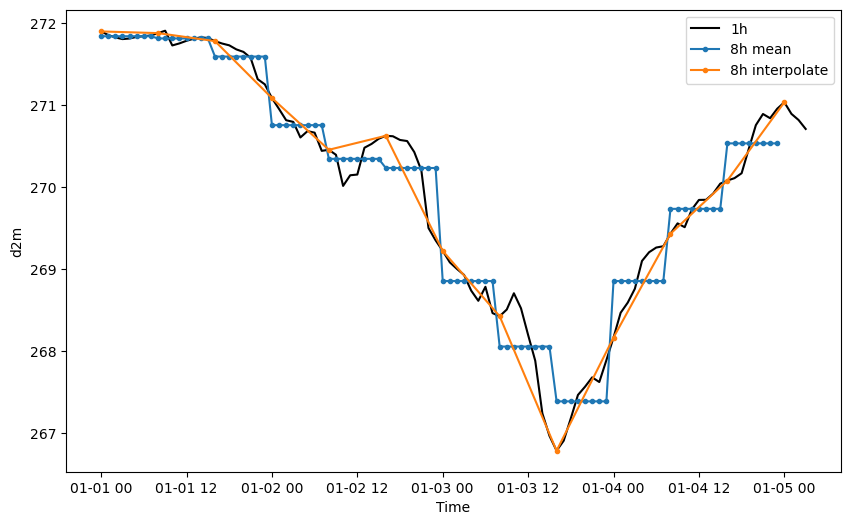

In [71]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

ax.set_xlabel('Time')
ax.set_ylabel('d2m')

ax.plot(var_1h.time, var_1h, '-k', label='1h')
ax.plot(var_1h.time.isel(time=slice(0,96)), np.repeat(np.array(hour8), 8), '.-', label='8h mean')
# ax.plot(var_8h.time, var_8h, '.-', label='8h resample mean')
ax.plot(var_8h.time, var_8h_interp, '.-', label='8h interpolate')
# ax.plot(var_1h.time.isel(time=slice(0,96)), np.repeat(np.array(daily), 24), '.-', label='24h mean')
# ax.plot(var_8h.time, var_8h, '.-', label='8h')
# ax.plot(var_24h.time, var_24h, '.-', label='24h resample mean')

ax.legend()

In [6]:
# maybe try running the same but without time interpolate on?
## 


In [ ]:
# Convert one year of ERA5 data to the format and units required by MITgcm.
def process_era5 (in_dir, out_dir, year, six_hourly=True, first_year=False, last_year=False, prec=32):

    # Construct file paths for input and output files
    in_head = in_dir + 'era5_'
    var_in = ['msl', 't2m', 'd2m', 'u10', 'v10', 'tp', 'ssrd', 'strd', 'e']
    if six_hourly:
        accum_flag = '_2'
    in_tail = '_' + str(year) + '.nc'
    out_head = out_dir + 'ERA5_'
    var_out = ['apressure', 'atemp', 'aqh', 'uwind', 'vwind', 'precip', 'swdown', 'lwdown', 'evap']
    out_tail = '_' + str(year)

    # Also read the first time index for the starting date
    start_date = netcdf_time(first_file, monthly=False)[0]

    # Loop over variables
    for i in range(len(var_in)):
        
        in_file = in_head + var_in[i] + in_tail
        print(('Reading ' + in_file))
        data = read_netcdf(in_file, var_in[i])
        
        print('Processing')
        # Trim and flip over latitude
        data = data[:,:j_bound:-1,:]
        
        if var_in[i] in ['tp', 'ssrd', 'strd', 'e']:
            # Accumulated variables --- this is more complicated
            
            if six_hourly:
                # Need to read data from the following hour to interpolate to this hour. This was downloaded into separate files.
                in_file_2 = in_head + var_in[i] + accum_flag + in_tail
                print(('Reading ' + in_file_2))
                data_2 = read_netcdf(in_file_2, var_in[i])
                data_2 = data_2[:,:j_bound:-1,:]
            # not six_hourly will be dealt with after the first_year check
            
            if first_year:
                # The first 7 hours of the accumulated variables are missing during the first year of ERA5. Fill this missing period with data from the next available time indices.
                if six_hourly:
                    # The first file is missing two indices (hours 0 and 6)
                    data = np.concatenate((data[:2,:], data), axis=0)
                    # The second file is missing one index (hour 1)
                    data_2 = np.concatenate((data_2[:1,:], data_2), axis=0)
                else:
                    # The first file is missing 7 indices (hours 0 to 6)
                    data = np.concatenate((data[:7,:], data), axis=0)
                    
            if not six_hourly:
                # Now get data from the following hour. Just shift one timestep ahead.
                # First need data from the first hour of next year
                if last_year:
                    # There is no such data; just copy the last hour of this year
                    data_next = data[-1,:]
                else:
                    in_file_2 = in_head + var_in[i] + '_' + str(year+1) + '.nc'
                    data_next = read_netcdf(in_file_2, var_in[i], time_index=0)
                    data_next = data_next[:j_bound:-1,:]  
                data_2 = np.concatenate((data[1:,:], np.expand_dims(data_next,0)), axis=0)
                
            # Now we can interpolate to the given hour: just the mean of either side
            data = 0.5*(data + data_2)
            # Convert from integrals to time-averages
            data /= 3600     # Length of ERA5 time interval in seconds dt

        return

In [15]:
orig = xr.open_dataset(f'{folder_in}t2m_y1979m01.nc')

In [16]:
orig

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 744)
Coordinates:
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time       (time) datetime64[ns] 1979-01-01 ... 1979-01-31T23:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.6
    history:      Fri Nov 17 19:17:17 2023: ncks --mk_rec_dmn time --cnk_dmn ...
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...
    NCO:          netCDF Operators version 5.0.3 (Homepage = http://nco.sf.ne...